# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:12<00:00, 4.86KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

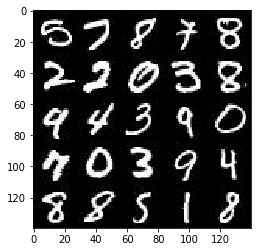

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

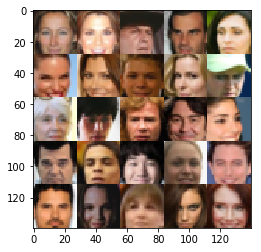

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [25]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        x1 = tf.maximum(0.2 * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2 * x2, x2)
 
        x3 = tf.layers.conv2d(x2, 256, 3, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2 * x3, x3)

        flat   = tf.contrib.layers.flatten(x3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [28]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse = not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)

    d_out_real, d_logits_real =  discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake =  discriminator(g_model, reuse=True)

    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_real, labels = tf.ones_like(d_out_real)* (1 - 0.1)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_fake, labels = tf.zeros_like(d_out_real)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_fake, labels = tf.ones_like(d_out_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return (d_loss,g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [33]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    samples, losses = [], []
    steps = 0
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], len(data_image_mode), z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, 0.5)

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                print('step # {}'.format(steps))
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images*2, 
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images*2, 
                                               input_z: batch_z,
                                               lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images*2})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps %100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

step # 1
step # 2
step # 3
step # 4
step # 5
step # 6
step # 7
step # 8
step # 9
step # 10
Epoch 1/2... Discriminator Loss: 1.0999... Generator Loss: 0.8735
step # 11
step # 12
step # 13
step # 14
step # 15
step # 16
step # 17
step # 18
step # 19
step # 20
Epoch 1/2... Discriminator Loss: 1.2287... Generator Loss: 7.5339
step # 21
step # 22
step # 23
step # 24
step # 25
step # 26
step # 27
step # 28
step # 29
step # 30
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 1.8068
step # 31
step # 32
step # 33
step # 34
step # 35
step # 36
step # 37
step # 38
step # 39
step # 40
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 0.6344
step # 41
step # 42
step # 43
step # 44
step # 45
step # 46
step # 47
step # 48
step # 49
step # 50
Epoch 1/2... Discriminator Loss: 1.3144... Generator Loss: 1.0906
step # 51
step # 52
step # 53
step # 54
step # 55
step # 56
step # 57
step # 58
step # 59
step # 60
Epoch 1/2... Discriminator Loss: 1.9321... Generator Loss: 0.4052
step # 61
ste

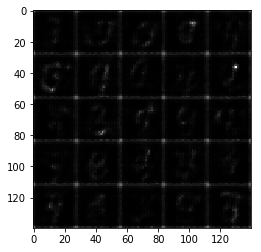

step # 101
step # 102
step # 103
step # 104
step # 105
step # 106
step # 107
step # 108
step # 109
step # 110
Epoch 1/2... Discriminator Loss: 1.7154... Generator Loss: 0.3676
step # 111
step # 112
step # 113
step # 114
step # 115
step # 116
step # 117
step # 118
step # 119
step # 120
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.6567
step # 121
step # 122
step # 123
step # 124
step # 125
step # 126
step # 127
step # 128
step # 129
step # 130
Epoch 1/2... Discriminator Loss: 1.5637... Generator Loss: 0.4214
step # 131
step # 132
step # 133
step # 134
step # 135
step # 136
step # 137
step # 138
step # 139
step # 140
Epoch 1/2... Discriminator Loss: 1.4168... Generator Loss: 0.5140
step # 141
step # 142
step # 143
step # 144
step # 145
step # 146
step # 147
step # 148
step # 149
step # 150
Epoch 1/2... Discriminator Loss: 1.2378... Generator Loss: 1.4887
step # 151
step # 152
step # 153
step # 154
step # 155
step # 156
step # 157
step # 158
step # 159
step # 160
Epoch 1/2.

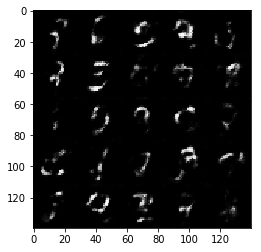

step # 201
step # 202
step # 203
step # 204
step # 205
step # 206
step # 207
step # 208
step # 209
step # 210
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 1.6156
step # 211
step # 212
step # 213
step # 214
step # 215
step # 216
step # 217
step # 218
step # 219
step # 220
Epoch 1/2... Discriminator Loss: 1.1323... Generator Loss: 0.8426
step # 221
step # 222
step # 223
step # 224
step # 225
step # 226
step # 227
step # 228
step # 229
step # 230
Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.5474
step # 231
step # 232
step # 233
step # 234
step # 235
step # 236
step # 237
step # 238
step # 239
step # 240
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 1.5870
step # 241
step # 242
step # 243
step # 244
step # 245
step # 246
step # 247
step # 248
step # 249
step # 250
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 0.8247
step # 251
step # 252
step # 253
step # 254
step # 255
step # 256
step # 257
step # 258
step # 259
step # 260
Epoch 1/2.

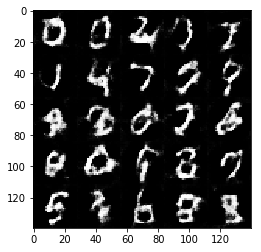

step # 301
step # 302
step # 303
step # 304
step # 305
step # 306
step # 307
step # 308
step # 309
step # 310
Epoch 1/2... Discriminator Loss: 1.4549... Generator Loss: 0.5021
step # 311
step # 312
step # 313
step # 314
step # 315
step # 316
step # 317
step # 318
step # 319
step # 320
Epoch 1/2... Discriminator Loss: 1.7787... Generator Loss: 0.3184
step # 321
step # 322
step # 323
step # 324
step # 325
step # 326
step # 327
step # 328
step # 329
step # 330
Epoch 1/2... Discriminator Loss: 1.1585... Generator Loss: 1.0005
step # 331
step # 332
step # 333
step # 334
step # 335
step # 336
step # 337
step # 338
step # 339
step # 340
Epoch 1/2... Discriminator Loss: 1.2450... Generator Loss: 0.7970
step # 341
step # 342
step # 343
step # 344
step # 345
step # 346
step # 347
step # 348
step # 349
step # 350
Epoch 1/2... Discriminator Loss: 1.3311... Generator Loss: 0.5881
step # 351
step # 352
step # 353
step # 354
step # 355
step # 356
step # 357
step # 358
step # 359
step # 360
Epoch 1/2.

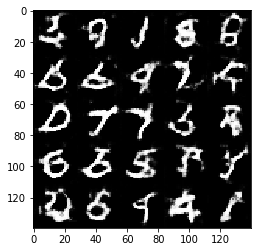

step # 401
step # 402
step # 403
step # 404
step # 405
step # 406
step # 407
step # 408
step # 409
step # 410
Epoch 1/2... Discriminator Loss: 1.1835... Generator Loss: 0.7840
step # 411
step # 412
step # 413
step # 414
step # 415
step # 416
step # 417
step # 418
step # 419
step # 420
Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 1.7946
step # 421
step # 422
step # 423
step # 424
step # 425
step # 426
step # 427
step # 428
step # 429
step # 430
Epoch 1/2... Discriminator Loss: 1.1565... Generator Loss: 1.4151
step # 431
step # 432
step # 433
step # 434
step # 435
step # 436
step # 437
step # 438
step # 439
step # 440
Epoch 1/2... Discriminator Loss: 1.1236... Generator Loss: 0.9471
step # 441
step # 442
step # 443
step # 444
step # 445
step # 446
step # 447
step # 448
step # 449
step # 450
Epoch 1/2... Discriminator Loss: 2.3083... Generator Loss: 3.0362
step # 451
step # 452
step # 453
step # 454
step # 455
step # 456
step # 457
step # 458
step # 459
step # 460
Epoch 1/2.

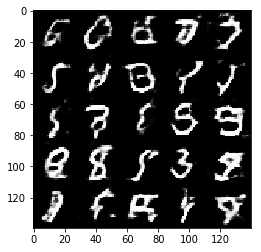

step # 501
step # 502
step # 503
step # 504
step # 505
step # 506
step # 507
step # 508
step # 509
step # 510
Epoch 1/2... Discriminator Loss: 1.1399... Generator Loss: 0.8552
step # 511
step # 512
step # 513
step # 514
step # 515
step # 516
step # 517
step # 518
step # 519
step # 520
Epoch 1/2... Discriminator Loss: 1.5698... Generator Loss: 0.4249
step # 521
step # 522
step # 523
step # 524
step # 525
step # 526
step # 527
step # 528
step # 529
step # 530
Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 1.2852
step # 531
step # 532
step # 533
step # 534
step # 535
step # 536
step # 537
step # 538
step # 539
step # 540
Epoch 1/2... Discriminator Loss: 1.2798... Generator Loss: 0.6081
step # 541
step # 542
step # 543
step # 544
step # 545
step # 546
step # 547
step # 548
step # 549
step # 550
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 1.2015
step # 551
step # 552
step # 553
step # 554
step # 555
step # 556
step # 557
step # 558
step # 559
step # 560
Epoch 1/2.

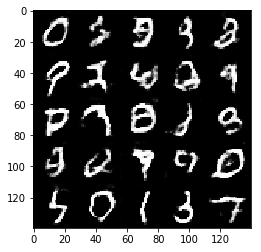

step # 601
step # 602
step # 603
step # 604
step # 605
step # 606
step # 607
step # 608
step # 609
step # 610
Epoch 1/2... Discriminator Loss: 1.2173... Generator Loss: 1.8322
step # 611
step # 612
step # 613
step # 614
step # 615
step # 616
step # 617
step # 618
step # 619
step # 620
Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 1.0351
step # 621
step # 622
step # 623
step # 624
step # 625
step # 626
step # 627
step # 628
step # 629
step # 630
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 0.8246
step # 631
step # 632
step # 633
step # 634
step # 635
step # 636
step # 637
step # 638
step # 639
step # 640
Epoch 1/2... Discriminator Loss: 1.0641... Generator Loss: 0.7799
step # 641
step # 642
step # 643
step # 644
step # 645
step # 646
step # 647
step # 648
step # 649
step # 650
Epoch 1/2... Discriminator Loss: 0.9282... Generator Loss: 1.2926
step # 651
step # 652
step # 653
step # 654
step # 655
step # 656
step # 657
step # 658
step # 659
step # 660
Epoch 1/2.

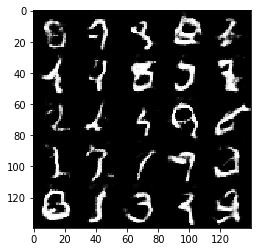

step # 701
step # 702
step # 703
step # 704
step # 705
step # 706
step # 707
step # 708
step # 709
step # 710
Epoch 1/2... Discriminator Loss: 1.0308... Generator Loss: 1.2826
step # 711
step # 712
step # 713
step # 714
step # 715
step # 716
step # 717
step # 718
step # 719
step # 720
Epoch 1/2... Discriminator Loss: 0.9120... Generator Loss: 1.4179
step # 721
step # 722
step # 723
step # 724
step # 725
step # 726
step # 727
step # 728
step # 729
step # 730
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 0.8710
step # 731
step # 732
step # 733
step # 734
step # 735
step # 736
step # 737
step # 738
step # 739
step # 740
Epoch 1/2... Discriminator Loss: 0.8716... Generator Loss: 1.1095
step # 741
step # 742
step # 743
step # 744
step # 745
step # 746
step # 747
step # 748
step # 749
step # 750
Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 0.8305
step # 751
step # 752
step # 753
step # 754
step # 755
step # 756
step # 757
step # 758
step # 759
step # 760
Epoch 1/2.

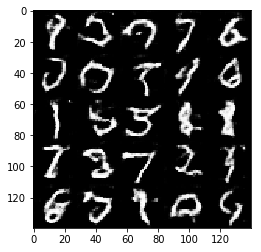

step # 801
step # 802
step # 803
step # 804
step # 805
step # 806
step # 807
step # 808
step # 809
step # 810
Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 1.0276
step # 811
step # 812
step # 813
step # 814
step # 815
step # 816
step # 817
step # 818
step # 819
step # 820
Epoch 1/2... Discriminator Loss: 1.3707... Generator Loss: 0.5314
step # 821
step # 822
step # 823
step # 824
step # 825
step # 826
step # 827
step # 828
step # 829
step # 830
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 1.4883
step # 831
step # 832
step # 833
step # 834
step # 835
step # 836
step # 837
step # 838
step # 839
step # 840
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 1.1113
step # 841
step # 842
step # 843
step # 844
step # 845
step # 846
step # 847
step # 848
step # 849
step # 850
Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 1.9741
step # 851
step # 852
step # 853
step # 854
step # 855
step # 856
step # 857
step # 858
step # 859
step # 860
Epoch 1/2.

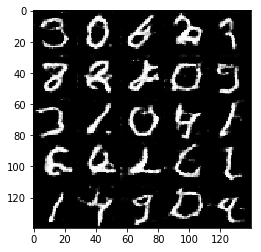

step # 901
step # 902
step # 903
step # 904
step # 905
step # 906
step # 907
step # 908
step # 909
step # 910
Epoch 1/2... Discriminator Loss: 0.7421... Generator Loss: 1.5658
step # 911
step # 912
step # 913
step # 914
step # 915
step # 916
step # 917
step # 918
step # 919
step # 920
Epoch 1/2... Discriminator Loss: 0.8745... Generator Loss: 1.0583
step # 921
step # 922
step # 923
step # 924
step # 925
step # 926
step # 927
step # 928
step # 929
step # 930
Epoch 1/2... Discriminator Loss: 0.8727... Generator Loss: 1.1197
step # 931
step # 932
step # 933
step # 934
step # 935
step # 936
step # 937
step # 938
step # 939
step # 940
Epoch 2/2... Discriminator Loss: 0.8359... Generator Loss: 1.4101
step # 941
step # 942
step # 943
step # 944
step # 945
step # 946
step # 947
step # 948
step # 949
step # 950
Epoch 2/2... Discriminator Loss: 1.1623... Generator Loss: 0.7302
step # 951
step # 952
step # 953
step # 954
step # 955
step # 956
step # 957
step # 958
step # 959
step # 960
Epoch 2/2.

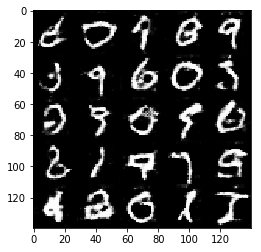

step # 1001
step # 1002
step # 1003
step # 1004
step # 1005
step # 1006
step # 1007
step # 1008
step # 1009
step # 1010
Epoch 2/2... Discriminator Loss: 0.7747... Generator Loss: 1.6790
step # 1011
step # 1012
step # 1013
step # 1014
step # 1015
step # 1016
step # 1017
step # 1018
step # 1019
step # 1020
Epoch 2/2... Discriminator Loss: 2.5775... Generator Loss: 0.2182
step # 1021
step # 1022
step # 1023
step # 1024
step # 1025
step # 1026
step # 1027
step # 1028
step # 1029
step # 1030
Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 0.6253
step # 1031
step # 1032
step # 1033
step # 1034
step # 1035
step # 1036
step # 1037
step # 1038
step # 1039
step # 1040
Epoch 2/2... Discriminator Loss: 0.8460... Generator Loss: 1.0801
step # 1041
step # 1042
step # 1043
step # 1044
step # 1045
step # 1046
step # 1047
step # 1048
step # 1049
step # 1050
Epoch 2/2... Discriminator Loss: 0.6366... Generator Loss: 1.7259
step # 1051
step # 1052
step # 1053
step # 1054
step # 1055
step # 105

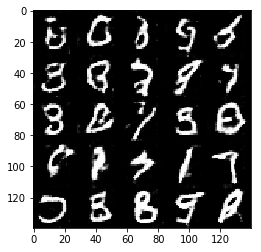

step # 1101
step # 1102
step # 1103
step # 1104
step # 1105
step # 1106
step # 1107
step # 1108
step # 1109
step # 1110
Epoch 2/2... Discriminator Loss: 0.9044... Generator Loss: 0.9892
step # 1111
step # 1112
step # 1113
step # 1114
step # 1115
step # 1116
step # 1117
step # 1118
step # 1119
step # 1120
Epoch 2/2... Discriminator Loss: 0.7640... Generator Loss: 1.3296
step # 1121
step # 1122
step # 1123
step # 1124
step # 1125
step # 1126
step # 1127
step # 1128
step # 1129
step # 1130
Epoch 2/2... Discriminator Loss: 0.9906... Generator Loss: 2.3945
step # 1131
step # 1132
step # 1133
step # 1134
step # 1135
step # 1136
step # 1137
step # 1138
step # 1139
step # 1140
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 1.0572
step # 1141
step # 1142
step # 1143
step # 1144
step # 1145
step # 1146
step # 1147
step # 1148
step # 1149
step # 1150
Epoch 2/2... Discriminator Loss: 1.6185... Generator Loss: 0.3758
step # 1151
step # 1152
step # 1153
step # 1154
step # 1155
step # 115

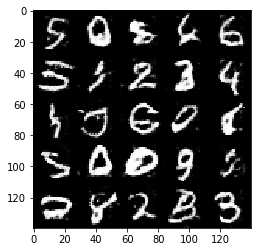

step # 1201
step # 1202
step # 1203
step # 1204
step # 1205
step # 1206
step # 1207
step # 1208
step # 1209
step # 1210
Epoch 2/2... Discriminator Loss: 1.0412... Generator Loss: 0.9447
step # 1211
step # 1212
step # 1213
step # 1214
step # 1215
step # 1216
step # 1217
step # 1218
step # 1219
step # 1220
Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 1.2030
step # 1221
step # 1222
step # 1223
step # 1224
step # 1225
step # 1226
step # 1227
step # 1228
step # 1229
step # 1230
Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 1.1288
step # 1231
step # 1232
step # 1233
step # 1234
step # 1235
step # 1236
step # 1237
step # 1238
step # 1239
step # 1240
Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 2.3407
step # 1241
step # 1242
step # 1243
step # 1244
step # 1245
step # 1246
step # 1247
step # 1248
step # 1249
step # 1250
Epoch 2/2... Discriminator Loss: 0.7350... Generator Loss: 1.4410
step # 1251
step # 1252
step # 1253
step # 1254
step # 1255
step # 125

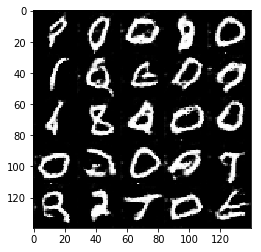

step # 1301
step # 1302
step # 1303
step # 1304
step # 1305
step # 1306
step # 1307
step # 1308
step # 1309
step # 1310
Epoch 2/2... Discriminator Loss: 1.4498... Generator Loss: 0.5020
step # 1311
step # 1312
step # 1313
step # 1314
step # 1315
step # 1316
step # 1317
step # 1318
step # 1319
step # 1320
Epoch 2/2... Discriminator Loss: 1.0103... Generator Loss: 0.8432
step # 1321
step # 1322
step # 1323
step # 1324
step # 1325
step # 1326
step # 1327
step # 1328
step # 1329
step # 1330
Epoch 2/2... Discriminator Loss: 0.7435... Generator Loss: 1.8603
step # 1331
step # 1332
step # 1333
step # 1334
step # 1335
step # 1336
step # 1337
step # 1338
step # 1339
step # 1340
Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 1.1451
step # 1341
step # 1342
step # 1343
step # 1344
step # 1345
step # 1346
step # 1347
step # 1348
step # 1349
step # 1350
Epoch 2/2... Discriminator Loss: 2.1413... Generator Loss: 0.2941
step # 1351
step # 1352
step # 1353
step # 1354
step # 1355
step # 135

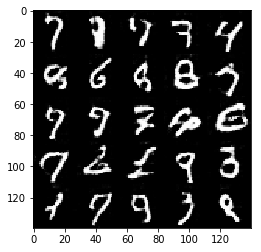

step # 1401
step # 1402
step # 1403
step # 1404
step # 1405
step # 1406
step # 1407
step # 1408
step # 1409
step # 1410
Epoch 2/2... Discriminator Loss: 0.8968... Generator Loss: 1.2004
step # 1411
step # 1412
step # 1413
step # 1414
step # 1415
step # 1416
step # 1417
step # 1418
step # 1419
step # 1420
Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 0.8309
step # 1421
step # 1422
step # 1423
step # 1424
step # 1425
step # 1426
step # 1427
step # 1428
step # 1429
step # 1430
Epoch 2/2... Discriminator Loss: 0.7657... Generator Loss: 1.2313
step # 1431
step # 1432
step # 1433
step # 1434
step # 1435
step # 1436
step # 1437
step # 1438
step # 1439
step # 1440
Epoch 2/2... Discriminator Loss: 1.3984... Generator Loss: 0.6597
step # 1441
step # 1442
step # 1443
step # 1444
step # 1445
step # 1446
step # 1447
step # 1448
step # 1449
step # 1450
Epoch 2/2... Discriminator Loss: 0.9500... Generator Loss: 1.6309
step # 1451
step # 1452
step # 1453
step # 1454
step # 1455
step # 145

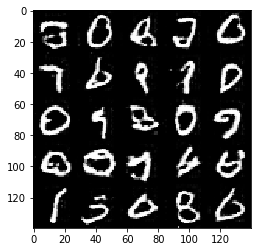

step # 1501
step # 1502
step # 1503
step # 1504
step # 1505
step # 1506
step # 1507
step # 1508
step # 1509
step # 1510
Epoch 2/2... Discriminator Loss: 1.0827... Generator Loss: 0.8288
step # 1511
step # 1512
step # 1513
step # 1514
step # 1515
step # 1516
step # 1517
step # 1518
step # 1519
step # 1520
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 2.4094
step # 1521
step # 1522
step # 1523
step # 1524
step # 1525
step # 1526
step # 1527
step # 1528
step # 1529
step # 1530
Epoch 2/2... Discriminator Loss: 1.6982... Generator Loss: 2.4256
step # 1531
step # 1532
step # 1533
step # 1534
step # 1535
step # 1536
step # 1537
step # 1538
step # 1539
step # 1540
Epoch 2/2... Discriminator Loss: 0.6214... Generator Loss: 3.0690
step # 1541
step # 1542
step # 1543
step # 1544
step # 1545
step # 1546
step # 1547
step # 1548
step # 1549
step # 1550
Epoch 2/2... Discriminator Loss: 0.7843... Generator Loss: 1.5017
step # 1551
step # 1552
step # 1553
step # 1554
step # 1555
step # 155

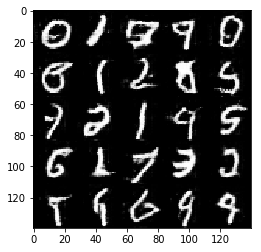

step # 1601
step # 1602
step # 1603
step # 1604
step # 1605
step # 1606
step # 1607
step # 1608
step # 1609
step # 1610
Epoch 2/2... Discriminator Loss: 1.2430... Generator Loss: 2.1771
step # 1611
step # 1612
step # 1613
step # 1614
step # 1615
step # 1616
step # 1617
step # 1618
step # 1619
step # 1620
Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 0.6070
step # 1621
step # 1622
step # 1623
step # 1624
step # 1625
step # 1626
step # 1627
step # 1628
step # 1629
step # 1630
Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 1.4430
step # 1631
step # 1632
step # 1633
step # 1634
step # 1635
step # 1636
step # 1637
step # 1638
step # 1639
step # 1640
Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 1.2633
step # 1641
step # 1642
step # 1643
step # 1644
step # 1645
step # 1646
step # 1647
step # 1648
step # 1649
step # 1650
Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 1.0016
step # 1651
step # 1652
step # 1653
step # 1654
step # 1655
step # 165

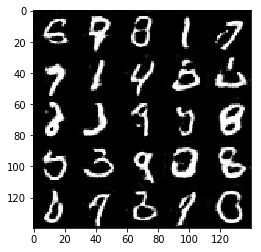

step # 1701
step # 1702
step # 1703
step # 1704
step # 1705
step # 1706
step # 1707
step # 1708
step # 1709
step # 1710
Epoch 2/2... Discriminator Loss: 0.6882... Generator Loss: 1.8514
step # 1711
step # 1712
step # 1713
step # 1714
step # 1715
step # 1716
step # 1717
step # 1718
step # 1719
step # 1720
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 0.9448
step # 1721
step # 1722
step # 1723
step # 1724
step # 1725
step # 1726
step # 1727
step # 1728
step # 1729
step # 1730
Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 0.7291
step # 1731
step # 1732
step # 1733
step # 1734
step # 1735
step # 1736
step # 1737
step # 1738
step # 1739
step # 1740
Epoch 2/2... Discriminator Loss: 0.7083... Generator Loss: 1.8822
step # 1741
step # 1742
step # 1743
step # 1744
step # 1745
step # 1746
step # 1747
step # 1748
step # 1749
step # 1750
Epoch 2/2... Discriminator Loss: 0.7825... Generator Loss: 1.3261
step # 1751
step # 1752
step # 1753
step # 1754
step # 1755
step # 175

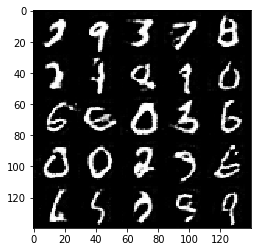

step # 1801
step # 1802
step # 1803
step # 1804
step # 1805
step # 1806
step # 1807
step # 1808
step # 1809
step # 1810
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 1.3625
step # 1811
step # 1812
step # 1813
step # 1814
step # 1815
step # 1816
step # 1817
step # 1818
step # 1819
step # 1820
Epoch 2/2... Discriminator Loss: 1.1627... Generator Loss: 0.7233
step # 1821
step # 1822
step # 1823
step # 1824
step # 1825
step # 1826
step # 1827
step # 1828
step # 1829
step # 1830
Epoch 2/2... Discriminator Loss: 0.7417... Generator Loss: 1.5991
step # 1831
step # 1832
step # 1833
step # 1834
step # 1835
step # 1836
step # 1837
step # 1838
step # 1839
step # 1840
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 2.6879
step # 1841
step # 1842
step # 1843
step # 1844
step # 1845
step # 1846
step # 1847
step # 1848
step # 1849
step # 1850
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 2.3147
step # 1851
step # 1852
step # 1853
step # 1854
step # 1855
step # 185

In [34]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

step # 1
step # 2
step # 3
step # 4
step # 5
step # 6
step # 7
step # 8
step # 9
step # 10
Epoch 1/1... Discriminator Loss: 1.6468... Generator Loss: 0.9220
step # 11
step # 12
step # 13
step # 14
step # 15
step # 16
step # 17
step # 18
step # 19
step # 20
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.5060
step # 21
step # 22
step # 23
step # 24
step # 25
step # 26
step # 27
step # 28
step # 29
step # 30
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 3.5364
step # 31
step # 32
step # 33
step # 34
step # 35
step # 36
step # 37
step # 38
step # 39
step # 40
Epoch 1/1... Discriminator Loss: 1.7541... Generator Loss: 4.9324
step # 41
step # 42
step # 43
step # 44
step # 45
step # 46
step # 47
step # 48
step # 49
step # 50
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.4271
step # 51
step # 52
step # 53
step # 54
step # 55
step # 56
step # 57
step # 58
step # 59
step # 60
Epoch 1/1... Discriminator Loss: 2.5718... Generator Loss: 0.1653
step # 61
ste

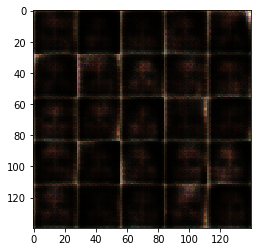

step # 101
step # 102
step # 103
step # 104
step # 105
step # 106
step # 107
step # 108
step # 109
step # 110
Epoch 1/1... Discriminator Loss: 2.0009... Generator Loss: 0.2948
step # 111
step # 112
step # 113
step # 114
step # 115
step # 116
step # 117
step # 118
step # 119
step # 120
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 0.9254
step # 121
step # 122
step # 123
step # 124
step # 125
step # 126
step # 127
step # 128
step # 129
step # 130
Epoch 1/1... Discriminator Loss: 1.6168... Generator Loss: 0.4343
step # 131
step # 132
step # 133
step # 134
step # 135
step # 136
step # 137
step # 138
step # 139
step # 140
Epoch 1/1... Discriminator Loss: 0.7584... Generator Loss: 2.2258
step # 141
step # 142
step # 143
step # 144
step # 145
step # 146
step # 147
step # 148
step # 149
step # 150
Epoch 1/1... Discriminator Loss: 2.1750... Generator Loss: 0.2235
step # 151
step # 152
step # 153
step # 154
step # 155
step # 156
step # 157
step # 158
step # 159
step # 160
Epoch 1/1.

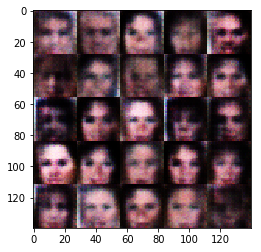

step # 201
step # 202
step # 203
step # 204
step # 205
step # 206
step # 207
step # 208
step # 209
step # 210
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 1.6799
step # 211
step # 212
step # 213
step # 214
step # 215
step # 216
step # 217
step # 218
step # 219
step # 220
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.9805
step # 221
step # 222
step # 223
step # 224
step # 225
step # 226
step # 227
step # 228
step # 229
step # 230
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.7630
step # 231
step # 232
step # 233
step # 234
step # 235
step # 236
step # 237
step # 238
step # 239
step # 240
Epoch 1/1... Discriminator Loss: 2.3000... Generator Loss: 0.2064
step # 241
step # 242
step # 243
step # 244
step # 245
step # 246
step # 247
step # 248
step # 249
step # 250
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.9022
step # 251
step # 252
step # 253
step # 254
step # 255
step # 256
step # 257
step # 258
step # 259
step # 260
Epoch 1/1.

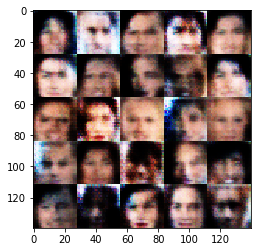

step # 301
step # 302
step # 303
step # 304
step # 305
step # 306
step # 307
step # 308
step # 309
step # 310
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.5603
step # 311
step # 312
step # 313
step # 314
step # 315
step # 316
step # 317
step # 318
step # 319
step # 320
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 0.9325
step # 321
step # 322
step # 323
step # 324
step # 325
step # 326
step # 327
step # 328
step # 329
step # 330
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.4441
step # 331
step # 332
step # 333
step # 334
step # 335
step # 336
step # 337
step # 338
step # 339
step # 340
Epoch 1/1... Discriminator Loss: 2.1553... Generator Loss: 0.2333
step # 341
step # 342
step # 343
step # 344
step # 345
step # 346
step # 347
step # 348
step # 349
step # 350
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.9731
step # 351
step # 352
step # 353
step # 354
step # 355
step # 356
step # 357
step # 358
step # 359
step # 360
Epoch 1/1.

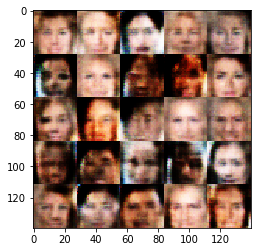

step # 401
step # 402
step # 403
step # 404
step # 405
step # 406
step # 407
step # 408
step # 409
step # 410
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.5990
step # 411
step # 412
step # 413
step # 414
step # 415
step # 416
step # 417
step # 418
step # 419
step # 420
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 2.3795
step # 421
step # 422
step # 423
step # 424
step # 425
step # 426
step # 427
step # 428
step # 429
step # 430
Epoch 1/1... Discriminator Loss: 1.5907... Generator Loss: 0.4184
step # 431
step # 432
step # 433
step # 434
step # 435
step # 436
step # 437
step # 438
step # 439
step # 440
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 2.9341
step # 441
step # 442
step # 443
step # 444
step # 445
step # 446
step # 447
step # 448
step # 449
step # 450
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.4033
step # 451
step # 452
step # 453
step # 454
step # 455
step # 456
step # 457
step # 458
step # 459
step # 460
Epoch 1/1.

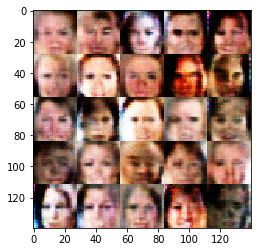

step # 501
step # 502
step # 503
step # 504
step # 505
step # 506
step # 507
step # 508
step # 509
step # 510
Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 2.1634
step # 511
step # 512
step # 513
step # 514
step # 515
step # 516
step # 517
step # 518
step # 519
step # 520
Epoch 1/1... Discriminator Loss: 0.7095... Generator Loss: 1.8398
step # 521
step # 522
step # 523
step # 524
step # 525
step # 526
step # 527
step # 528
step # 529
step # 530
Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 6.0304
step # 531
step # 532
step # 533
step # 534
step # 535
step # 536
step # 537
step # 538
step # 539
step # 540
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.5176
step # 541
step # 542
step # 543
step # 544
step # 545
step # 546
step # 547
step # 548
step # 549
step # 550
Epoch 1/1... Discriminator Loss: 1.7393... Generator Loss: 4.9278
step # 551
step # 552
step # 553
step # 554
step # 555
step # 556
step # 557
step # 558
step # 559
step # 560
Epoch 1/1.

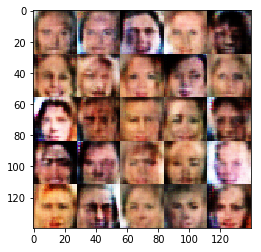

step # 601
step # 602
step # 603
step # 604
step # 605
step # 606
step # 607
step # 608
step # 609
step # 610
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.1612
step # 611
step # 612
step # 613
step # 614
step # 615
step # 616
step # 617
step # 618
step # 619
step # 620
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.3621
step # 621
step # 622
step # 623
step # 624
step # 625
step # 626
step # 627
step # 628
step # 629
step # 630
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.5354
step # 631
step # 632
step # 633
step # 634
step # 635
step # 636
step # 637
step # 638
step # 639
step # 640
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 1.2492
step # 641
step # 642
step # 643
step # 644
step # 645
step # 646
step # 647
step # 648
step # 649
step # 650
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 2.3008
step # 651
step # 652
step # 653
step # 654
step # 655
step # 656
step # 657
step # 658
step # 659
step # 660
Epoch 1/1.

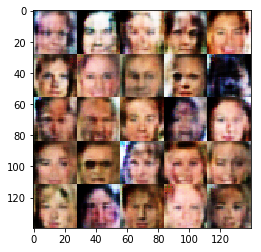

step # 701
step # 702
step # 703
step # 704
step # 705
step # 706
step # 707
step # 708
step # 709
step # 710
Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 1.2852
step # 711
step # 712
step # 713
step # 714
step # 715
step # 716
step # 717
step # 718
step # 719
step # 720
Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 2.1221
step # 721
step # 722
step # 723
step # 724
step # 725
step # 726
step # 727
step # 728
step # 729
step # 730
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 2.0166
step # 731
step # 732
step # 733
step # 734
step # 735
step # 736
step # 737
step # 738
step # 739
step # 740
Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 2.2747
step # 741
step # 742
step # 743
step # 744
step # 745
step # 746
step # 747
step # 748
step # 749
step # 750
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.6348
step # 751
step # 752
step # 753
step # 754
step # 755
step # 756
step # 757
step # 758
step # 759
step # 760
Epoch 1/1.

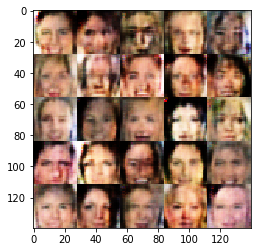

step # 801
step # 802
step # 803
step # 804
step # 805
step # 806
step # 807
step # 808
step # 809
step # 810
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 1.6718
step # 811
step # 812
step # 813
step # 814
step # 815
step # 816
step # 817
step # 818
step # 819
step # 820
Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 1.2864
step # 821
step # 822
step # 823
step # 824
step # 825
step # 826
step # 827
step # 828
step # 829
step # 830
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.5231
step # 831
step # 832
step # 833
step # 834
step # 835
step # 836
step # 837
step # 838
step # 839
step # 840
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 2.5632
step # 841
step # 842
step # 843
step # 844
step # 845
step # 846
step # 847
step # 848
step # 849
step # 850
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.2692
step # 851
step # 852
step # 853
step # 854
step # 855
step # 856
step # 857
step # 858
step # 859
step # 860
Epoch 1/1.

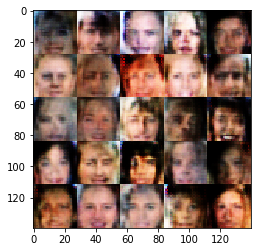

step # 901
step # 902
step # 903
step # 904
step # 905
step # 906
step # 907
step # 908
step # 909
step # 910
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.7436
step # 911
step # 912
step # 913
step # 914
step # 915
step # 916
step # 917
step # 918
step # 919
step # 920
Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.4668
step # 921
step # 922
step # 923
step # 924
step # 925
step # 926
step # 927
step # 928
step # 929
step # 930
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.0917
step # 931
step # 932
step # 933
step # 934
step # 935
step # 936
step # 937
step # 938
step # 939
step # 940
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.8775
step # 941
step # 942
step # 943
step # 944
step # 945
step # 946
step # 947
step # 948
step # 949
step # 950
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 1.2735
step # 951
step # 952
step # 953
step # 954
step # 955
step # 956
step # 957
step # 958
step # 959
step # 960
Epoch 1/1.

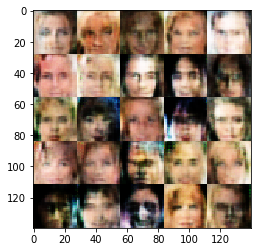

step # 1001
step # 1002
step # 1003
step # 1004
step # 1005
step # 1006
step # 1007
step # 1008
step # 1009
step # 1010
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.7983
step # 1011
step # 1012
step # 1013
step # 1014
step # 1015
step # 1016
step # 1017
step # 1018
step # 1019
step # 1020
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.6731
step # 1021
step # 1022
step # 1023
step # 1024
step # 1025
step # 1026
step # 1027
step # 1028
step # 1029
step # 1030
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 2.3740
step # 1031
step # 1032
step # 1033
step # 1034
step # 1035
step # 1036
step # 1037
step # 1038
step # 1039
step # 1040
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 1.2097
step # 1041
step # 1042
step # 1043
step # 1044
step # 1045
step # 1046
step # 1047
step # 1048
step # 1049
step # 1050
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 2.4596
step # 1051
step # 1052
step # 1053
step # 1054
step # 1055
step # 105

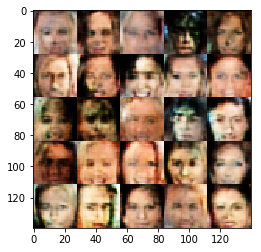

step # 1101
step # 1102
step # 1103
step # 1104
step # 1105
step # 1106
step # 1107
step # 1108
step # 1109
step # 1110
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 1.4242
step # 1111
step # 1112
step # 1113
step # 1114
step # 1115
step # 1116
step # 1117
step # 1118
step # 1119
step # 1120
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 1.7591
step # 1121
step # 1122
step # 1123
step # 1124
step # 1125
step # 1126
step # 1127
step # 1128
step # 1129
step # 1130
Epoch 1/1... Discriminator Loss: 2.2805... Generator Loss: 3.6105
step # 1131
step # 1132
step # 1133
step # 1134
step # 1135
step # 1136
step # 1137
step # 1138
step # 1139
step # 1140
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.7511
step # 1141
step # 1142
step # 1143
step # 1144
step # 1145
step # 1146
step # 1147
step # 1148
step # 1149
step # 1150
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 1.4000
step # 1151
step # 1152
step # 1153
step # 1154
step # 1155
step # 115

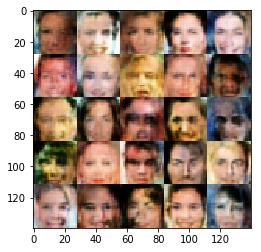

step # 1201
step # 1202
step # 1203
step # 1204
step # 1205
step # 1206
step # 1207
step # 1208
step # 1209
step # 1210
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.8111
step # 1211
step # 1212
step # 1213
step # 1214
step # 1215
step # 1216
step # 1217
step # 1218
step # 1219
step # 1220
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 2.3476
step # 1221
step # 1222
step # 1223
step # 1224
step # 1225
step # 1226
step # 1227
step # 1228
step # 1229
step # 1230
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.3735
step # 1231
step # 1232
step # 1233
step # 1234
step # 1235
step # 1236
step # 1237
step # 1238
step # 1239
step # 1240
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 1.6631
step # 1241
step # 1242
step # 1243
step # 1244
step # 1245
step # 1246
step # 1247
step # 1248
step # 1249
step # 1250
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 2.5149
step # 1251
step # 1252
step # 1253
step # 1254
step # 1255
step # 125

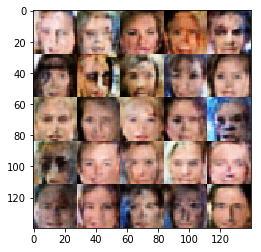

step # 1301
step # 1302
step # 1303
step # 1304
step # 1305
step # 1306
step # 1307
step # 1308
step # 1309
step # 1310
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.6476
step # 1311
step # 1312
step # 1313
step # 1314
step # 1315
step # 1316
step # 1317
step # 1318
step # 1319
step # 1320
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 1.4677
step # 1321
step # 1322
step # 1323
step # 1324
step # 1325
step # 1326
step # 1327
step # 1328
step # 1329
step # 1330
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 0.9052
step # 1331
step # 1332
step # 1333
step # 1334
step # 1335
step # 1336
step # 1337
step # 1338
step # 1339
step # 1340
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.7581
step # 1341
step # 1342
step # 1343
step # 1344
step # 1345
step # 1346
step # 1347
step # 1348
step # 1349
step # 1350
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.7707
step # 1351
step # 1352
step # 1353
step # 1354
step # 1355
step # 135

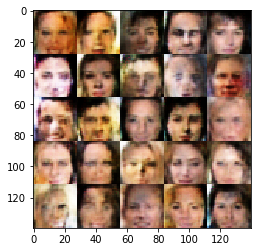

step # 1401
step # 1402
step # 1403
step # 1404
step # 1405
step # 1406
step # 1407
step # 1408
step # 1409
step # 1410
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 2.7576
step # 1411
step # 1412
step # 1413
step # 1414
step # 1415
step # 1416
step # 1417
step # 1418
step # 1419
step # 1420
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.1220
step # 1421
step # 1422
step # 1423
step # 1424
step # 1425
step # 1426
step # 1427
step # 1428
step # 1429
step # 1430
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.1292
step # 1431
step # 1432
step # 1433
step # 1434
step # 1435
step # 1436
step # 1437
step # 1438
step # 1439
step # 1440
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 1.9344
step # 1441
step # 1442
step # 1443
step # 1444
step # 1445
step # 1446
step # 1447
step # 1448
step # 1449
step # 1450
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 1.3695
step # 1451
step # 1452
step # 1453
step # 1454
step # 1455
step # 145

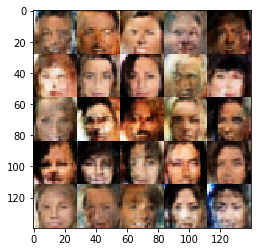

step # 1501
step # 1502
step # 1503
step # 1504
step # 1505
step # 1506
step # 1507
step # 1508
step # 1509
step # 1510
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 2.0692
step # 1511
step # 1512
step # 1513
step # 1514
step # 1515
step # 1516
step # 1517
step # 1518
step # 1519
step # 1520
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 1.8500
step # 1521
step # 1522
step # 1523
step # 1524
step # 1525
step # 1526
step # 1527
step # 1528
step # 1529
step # 1530
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 2.9289
step # 1531
step # 1532
step # 1533
step # 1534
step # 1535
step # 1536
step # 1537
step # 1538
step # 1539
step # 1540
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 2.5731
step # 1541
step # 1542
step # 1543
step # 1544
step # 1545
step # 1546
step # 1547
step # 1548
step # 1549
step # 1550
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.6338
step # 1551
step # 1552
step # 1553
step # 1554
step # 1555
step # 155

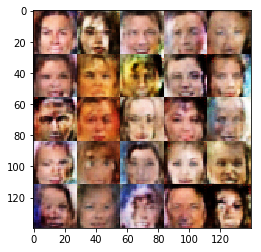

step # 1601
step # 1602
step # 1603
step # 1604
step # 1605
step # 1606
step # 1607
step # 1608
step # 1609
step # 1610
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.7531
step # 1611
step # 1612
step # 1613
step # 1614
step # 1615
step # 1616
step # 1617
step # 1618
step # 1619
step # 1620
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.0571
step # 1621
step # 1622
step # 1623
step # 1624
step # 1625
step # 1626
step # 1627
step # 1628
step # 1629
step # 1630
Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 4.0178
step # 1631
step # 1632
step # 1633
step # 1634
step # 1635
step # 1636
step # 1637
step # 1638
step # 1639
step # 1640
Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 3.1587
step # 1641
step # 1642
step # 1643
step # 1644
step # 1645
step # 1646
step # 1647
step # 1648
step # 1649
step # 1650
Epoch 1/1... Discriminator Loss: 0.8551... Generator Loss: 1.2114
step # 1651
step # 1652
step # 1653
step # 1654
step # 1655
step # 165

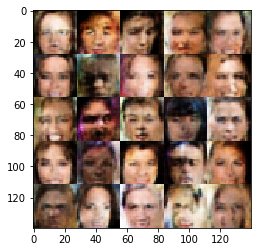

step # 1701
step # 1702
step # 1703
step # 1704
step # 1705
step # 1706
step # 1707
step # 1708
step # 1709
step # 1710
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 3.4790
step # 1711
step # 1712
step # 1713
step # 1714
step # 1715
step # 1716
step # 1717
step # 1718
step # 1719
step # 1720
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 1.2628
step # 1721
step # 1722
step # 1723
step # 1724
step # 1725
step # 1726
step # 1727
step # 1728
step # 1729
step # 1730
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.8441
step # 1731
step # 1732
step # 1733
step # 1734
step # 1735
step # 1736
step # 1737
step # 1738
step # 1739
step # 1740
Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.5077
step # 1741
step # 1742
step # 1743
step # 1744
step # 1745
step # 1746
step # 1747
step # 1748
step # 1749
step # 1750
Epoch 1/1... Discriminator Loss: 1.8411... Generator Loss: 0.3273
step # 1751
step # 1752
step # 1753
step # 1754
step # 1755
step # 175

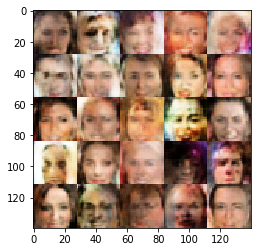

step # 1801
step # 1802
step # 1803
step # 1804
step # 1805
step # 1806
step # 1807
step # 1808
step # 1809
step # 1810
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 1.3884
step # 1811
step # 1812
step # 1813
step # 1814
step # 1815
step # 1816
step # 1817
step # 1818
step # 1819
step # 1820
Epoch 1/1... Discriminator Loss: 1.8224... Generator Loss: 0.3159
step # 1821
step # 1822
step # 1823
step # 1824
step # 1825
step # 1826
step # 1827
step # 1828
step # 1829
step # 1830
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6297
step # 1831
step # 1832
step # 1833
step # 1834
step # 1835
step # 1836
step # 1837
step # 1838
step # 1839
step # 1840
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.2223
step # 1841
step # 1842
step # 1843
step # 1844
step # 1845
step # 1846
step # 1847
step # 1848
step # 1849
step # 1850
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.0905
step # 1851
step # 1852
step # 1853
step # 1854
step # 1855
step # 185

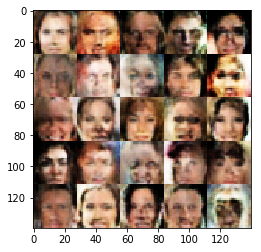

step # 1901
step # 1902
step # 1903
step # 1904
step # 1905
step # 1906
step # 1907
step # 1908
step # 1909
step # 1910
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.6927
step # 1911
step # 1912
step # 1913
step # 1914
step # 1915
step # 1916
step # 1917
step # 1918
step # 1919
step # 1920
Epoch 1/1... Discriminator Loss: 0.7909... Generator Loss: 1.6662
step # 1921
step # 1922
step # 1923
step # 1924
step # 1925
step # 1926
step # 1927
step # 1928
step # 1929
step # 1930
Epoch 1/1... Discriminator Loss: 0.6552... Generator Loss: 1.7939
step # 1931
step # 1932
step # 1933
step # 1934
step # 1935
step # 1936
step # 1937
step # 1938
step # 1939
step # 1940
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.6885
step # 1941
step # 1942
step # 1943
step # 1944
step # 1945
step # 1946
step # 1947
step # 1948
step # 1949
step # 1950
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.5930
step # 1951
step # 1952
step # 1953
step # 1954
step # 1955
step # 195

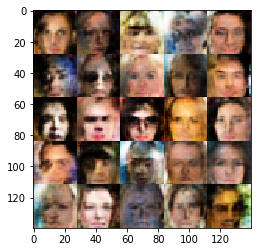

step # 2001
step # 2002
step # 2003
step # 2004
step # 2005
step # 2006
step # 2007
step # 2008
step # 2009
step # 2010
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.4987
step # 2011
step # 2012
step # 2013
step # 2014
step # 2015
step # 2016
step # 2017
step # 2018
step # 2019
step # 2020
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 2.0467
step # 2021
step # 2022
step # 2023
step # 2024
step # 2025
step # 2026
step # 2027
step # 2028
step # 2029
step # 2030
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 1.5977
step # 2031
step # 2032
step # 2033
step # 2034
step # 2035
step # 2036
step # 2037
step # 2038
step # 2039
step # 2040
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.1287
step # 2041
step # 2042
step # 2043
step # 2044
step # 2045
step # 2046
step # 2047
step # 2048
step # 2049
step # 2050
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.7027
step # 2051
step # 2052
step # 2053
step # 2054
step # 2055
step # 205

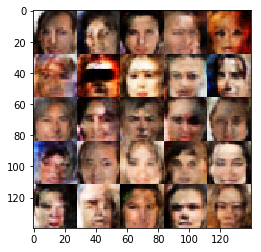

step # 2101
step # 2102
step # 2103
step # 2104
step # 2105
step # 2106
step # 2107
step # 2108
step # 2109
step # 2110
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.0108
step # 2111
step # 2112
step # 2113
step # 2114
step # 2115
step # 2116
step # 2117
step # 2118
step # 2119
step # 2120
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.6055
step # 2121
step # 2122
step # 2123
step # 2124
step # 2125
step # 2126
step # 2127
step # 2128
step # 2129
step # 2130
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.9904
step # 2131
step # 2132
step # 2133
step # 2134
step # 2135
step # 2136
step # 2137
step # 2138
step # 2139
step # 2140
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 1.2146
step # 2141
step # 2142
step # 2143
step # 2144
step # 2145
step # 2146
step # 2147
step # 2148
step # 2149
step # 2150
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.7062
step # 2151
step # 2152
step # 2153
step # 2154
step # 2155
step # 215

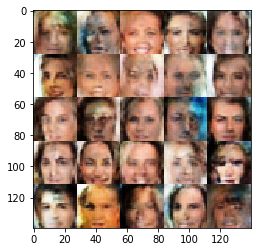

step # 2201
step # 2202
step # 2203
step # 2204
step # 2205
step # 2206
step # 2207
step # 2208
step # 2209
step # 2210
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.2339
step # 2211
step # 2212
step # 2213
step # 2214
step # 2215
step # 2216
step # 2217
step # 2218
step # 2219
step # 2220
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 1.3775
step # 2221
step # 2222
step # 2223
step # 2224
step # 2225
step # 2226
step # 2227
step # 2228
step # 2229
step # 2230
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.9169
step # 2231
step # 2232
step # 2233
step # 2234
step # 2235
step # 2236
step # 2237
step # 2238
step # 2239
step # 2240
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.7614
step # 2241
step # 2242
step # 2243
step # 2244
step # 2245
step # 2246
step # 2247
step # 2248
step # 2249
step # 2250
Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 1.8093
step # 2251
step # 2252
step # 2253
step # 2254
step # 2255
step # 225

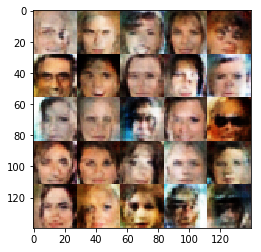

step # 2301
step # 2302
step # 2303
step # 2304
step # 2305
step # 2306
step # 2307
step # 2308
step # 2309
step # 2310
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 0.8394
step # 2311
step # 2312
step # 2313
step # 2314
step # 2315
step # 2316
step # 2317
step # 2318
step # 2319
step # 2320
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.6626
step # 2321
step # 2322
step # 2323
step # 2324
step # 2325
step # 2326
step # 2327
step # 2328
step # 2329
step # 2330
Epoch 1/1... Discriminator Loss: 0.6696... Generator Loss: 2.1400
step # 2331
step # 2332
step # 2333
step # 2334
step # 2335
step # 2336
step # 2337
step # 2338
step # 2339
step # 2340
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 2.2088
step # 2341
step # 2342
step # 2343
step # 2344
step # 2345
step # 2346
step # 2347
step # 2348
step # 2349
step # 2350
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.1278
step # 2351
step # 2352
step # 2353
step # 2354
step # 2355
step # 235

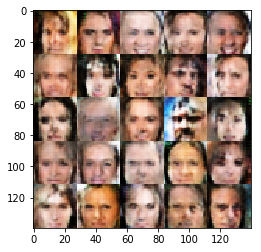

step # 2401
step # 2402
step # 2403
step # 2404
step # 2405
step # 2406
step # 2407
step # 2408
step # 2409
step # 2410
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.6143
step # 2411
step # 2412
step # 2413
step # 2414
step # 2415
step # 2416
step # 2417
step # 2418
step # 2419
step # 2420
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.6215
step # 2421
step # 2422
step # 2423
step # 2424
step # 2425
step # 2426
step # 2427
step # 2428
step # 2429
step # 2430
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.7948
step # 2431
step # 2432
step # 2433
step # 2434
step # 2435
step # 2436
step # 2437
step # 2438
step # 2439
step # 2440
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.0358
step # 2441
step # 2442
step # 2443
step # 2444
step # 2445
step # 2446
step # 2447
step # 2448
step # 2449
step # 2450
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 1.1390
step # 2451
step # 2452
step # 2453
step # 2454
step # 2455
step # 245

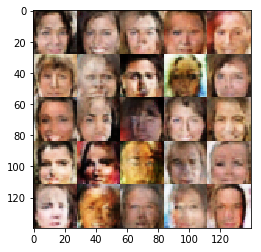

step # 2501
step # 2502
step # 2503
step # 2504
step # 2505
step # 2506
step # 2507
step # 2508
step # 2509
step # 2510
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 2.4541
step # 2511
step # 2512
step # 2513
step # 2514
step # 2515
step # 2516
step # 2517
step # 2518
step # 2519
step # 2520
Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 1.4302
step # 2521
step # 2522
step # 2523
step # 2524
step # 2525
step # 2526
step # 2527
step # 2528
step # 2529
step # 2530
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 1.8477
step # 2531
step # 2532
step # 2533
step # 2534
step # 2535
step # 2536
step # 2537
step # 2538
step # 2539
step # 2540
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.4395
step # 2541
step # 2542
step # 2543
step # 2544
step # 2545
step # 2546
step # 2547
step # 2548
step # 2549
step # 2550
Epoch 1/1... Discriminator Loss: 1.6241... Generator Loss: 0.4151
step # 2551
step # 2552
step # 2553
step # 2554
step # 2555
step # 255

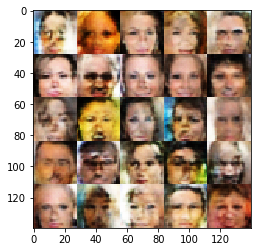

step # 2601
step # 2602
step # 2603
step # 2604
step # 2605
step # 2606
step # 2607
step # 2608
step # 2609
step # 2610
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.4568
step # 2611
step # 2612
step # 2613
step # 2614
step # 2615
step # 2616
step # 2617
step # 2618
step # 2619
step # 2620
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.6081
step # 2621
step # 2622
step # 2623
step # 2624
step # 2625
step # 2626
step # 2627
step # 2628
step # 2629
step # 2630
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 2.5061
step # 2631
step # 2632
step # 2633
step # 2634
step # 2635
step # 2636
step # 2637
step # 2638
step # 2639
step # 2640
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 1.2499
step # 2641
step # 2642
step # 2643
step # 2644
step # 2645
step # 2646
step # 2647
step # 2648
step # 2649
step # 2650
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.0515
step # 2651
step # 2652
step # 2653
step # 2654
step # 2655
step # 265

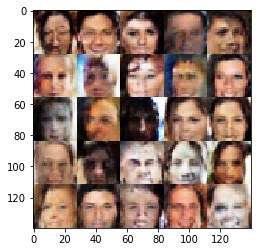

step # 2701
step # 2702
step # 2703
step # 2704
step # 2705
step # 2706
step # 2707
step # 2708
step # 2709
step # 2710
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.8795
step # 2711
step # 2712
step # 2713
step # 2714
step # 2715
step # 2716
step # 2717
step # 2718
step # 2719
step # 2720
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 1.4563
step # 2721
step # 2722
step # 2723
step # 2724
step # 2725
step # 2726
step # 2727
step # 2728
step # 2729
step # 2730
Epoch 1/1... Discriminator Loss: 0.8849... Generator Loss: 1.3719
step # 2731
step # 2732
step # 2733
step # 2734
step # 2735
step # 2736
step # 2737
step # 2738
step # 2739
step # 2740
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 1.6739
step # 2741
step # 2742
step # 2743
step # 2744
step # 2745
step # 2746
step # 2747
step # 2748
step # 2749
step # 2750
Epoch 1/1... Discriminator Loss: 0.7378... Generator Loss: 1.4492
step # 2751
step # 2752
step # 2753
step # 2754
step # 2755
step # 275

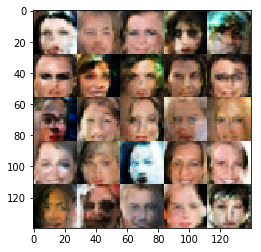

step # 2801
step # 2802
step # 2803
step # 2804
step # 2805
step # 2806
step # 2807
step # 2808
step # 2809
step # 2810
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.7111
step # 2811
step # 2812
step # 2813
step # 2814
step # 2815
step # 2816
step # 2817
step # 2818
step # 2819
step # 2820
Epoch 1/1... Discriminator Loss: 0.4564... Generator Loss: 3.0034
step # 2821
step # 2822
step # 2823
step # 2824
step # 2825
step # 2826
step # 2827
step # 2828
step # 2829
step # 2830
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 1.2405
step # 2831
step # 2832
step # 2833
step # 2834
step # 2835
step # 2836
step # 2837
step # 2838
step # 2839
step # 2840
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.6208
step # 2841
step # 2842
step # 2843
step # 2844
step # 2845
step # 2846
step # 2847
step # 2848
step # 2849
step # 2850
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 0.9138
step # 2851
step # 2852
step # 2853
step # 2854
step # 2855
step # 285

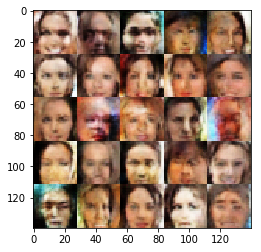

step # 2901
step # 2902
step # 2903
step # 2904
step # 2905
step # 2906
step # 2907
step # 2908
step # 2909
step # 2910
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.6835
step # 2911
step # 2912
step # 2913
step # 2914
step # 2915
step # 2916
step # 2917
step # 2918
step # 2919
step # 2920
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 1.1043
step # 2921
step # 2922
step # 2923
step # 2924
step # 2925
step # 2926
step # 2927
step # 2928
step # 2929
step # 2930
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.8620
step # 2931
step # 2932
step # 2933
step # 2934
step # 2935
step # 2936
step # 2937
step # 2938
step # 2939
step # 2940
Epoch 1/1... Discriminator Loss: 1.6186... Generator Loss: 0.4207
step # 2941
step # 2942
step # 2943
step # 2944
step # 2945
step # 2946
step # 2947
step # 2948
step # 2949
step # 2950
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.9765
step # 2951
step # 2952
step # 2953
step # 2954
step # 2955
step # 295

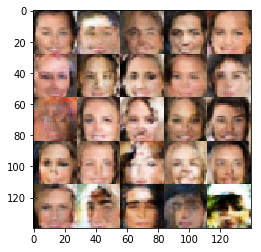

step # 3001
step # 3002
step # 3003
step # 3004
step # 3005
step # 3006
step # 3007
step # 3008
step # 3009
step # 3010
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6259
step # 3011
step # 3012
step # 3013
step # 3014
step # 3015
step # 3016
step # 3017
step # 3018
step # 3019
step # 3020
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.8110
step # 3021
step # 3022
step # 3023
step # 3024
step # 3025
step # 3026
step # 3027
step # 3028
step # 3029
step # 3030
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 1.1380
step # 3031
step # 3032
step # 3033
step # 3034
step # 3035
step # 3036
step # 3037
step # 3038
step # 3039
step # 3040
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.0979
step # 3041
step # 3042
step # 3043
step # 3044
step # 3045
step # 3046
step # 3047
step # 3048
step # 3049
step # 3050
Epoch 1/1... Discriminator Loss: 2.6098... Generator Loss: 3.2591
step # 3051
step # 3052
step # 3053
step # 3054
step # 3055
step # 305

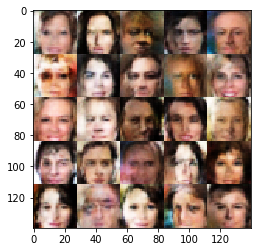

step # 3101
step # 3102
step # 3103
step # 3104
step # 3105
step # 3106
step # 3107
step # 3108
step # 3109
step # 3110
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 1.1072
step # 3111
step # 3112
step # 3113
step # 3114
step # 3115
step # 3116
step # 3117
step # 3118
step # 3119
step # 3120
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 2.4294
step # 3121
step # 3122
step # 3123
step # 3124
step # 3125
step # 3126
step # 3127
step # 3128
step # 3129
step # 3130
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.8144
step # 3131
step # 3132
step # 3133
step # 3134
step # 3135
step # 3136
step # 3137
step # 3138
step # 3139
step # 3140
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 1.5391
step # 3141
step # 3142
step # 3143
step # 3144
step # 3145
step # 3146
step # 3147
step # 3148
step # 3149
step # 3150
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.6848
step # 3151
step # 3152
step # 3153
step # 3154
step # 3155
step # 315

In [35]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.